In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

In [2]:
# Ignore warnings coming from the Fourier transform module to avoid generating 100s of them.
import warnings
warnings.filterwarnings("ignore", module="xrft")

# Generate synthetic data

First, we create a regular grid of observation points.

In [3]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [4]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [5]:
np.random.seed(5)
count_sources = np.array([250, 500, 1000, 1500]) #np.arange(100, 500, 100)
models = []
for sourcers in count_sources:
    dipole_coordinates = (
    np.random.randint(0, 2000, sourcers),  # µm
    np.random.randint(0, 2000, sourcers),  # µm
    np.random.randint(-20, -1, sourcers),  # µm
    ),
    dipole_moments = mg.angles_to_vector(
    inclination=np.random.normal(0, 10, sourcers),
    declination=np.random.normal(0, 10, sourcers),
    amplitude=abs(np.random.normal(0, 100, sourcers)*1.0E-14),
    )
    
    models.append((dipole_coordinates, dipole_moments))
    
# models[-1]

In [6]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)

variable_name = []
for count in count_sources:
    variable_name.append(('bz'+str(count)))

for (dipole_coordinates, dipole_moments), name in zip(models, variable_name):
    dipole_coordinates_ = (dipole_coordinates[0][0], dipole_coordinates[0][1], dipole_coordinates[0][2])
    
    bz = mg.dipole_bz(coordinates, dipole_coordinates_, dipole_moments)
    bz += mg.gaussian_noise(error=20, shape=(coordinates[1]).shape, seed=42)

    if name == variable_name[0]:
        data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=[name], dims=("y", "x"), extra_coords_names="z")
        data.x.attrs = {"units": "µm"}
        data.y.attrs = {"units": "µm"}
        data[name].attrs = {"long_name": "vertical magnetic field", "units": "nT"} 
    else:
        dataset_aux = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=[name], dims=("y", "x"), extra_coords_names="z")
        dataset_aux[name].attrs = {"long_name": "vertical magnetic field", "units": "nT"} 
        
        data.update(dataset_aux)

In [7]:
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz250    (y, x) float64 27.35 0.5623 36.48 40.39 ... -21.94 -1.925 -7.361
    bz500    (y, x) float64 -757.6 -1.016e+03 -1.278e+03 ... 302.0 310.0 292.6
    bz1000   (y, x) float64 -8.796 -36.41 -1.319 1.777 ... 64.24 77.71 66.35
    bz1500   (y, x) float64 -76.71 -109.5 -79.9 -82.73 ... 305.0 306.7 283.7

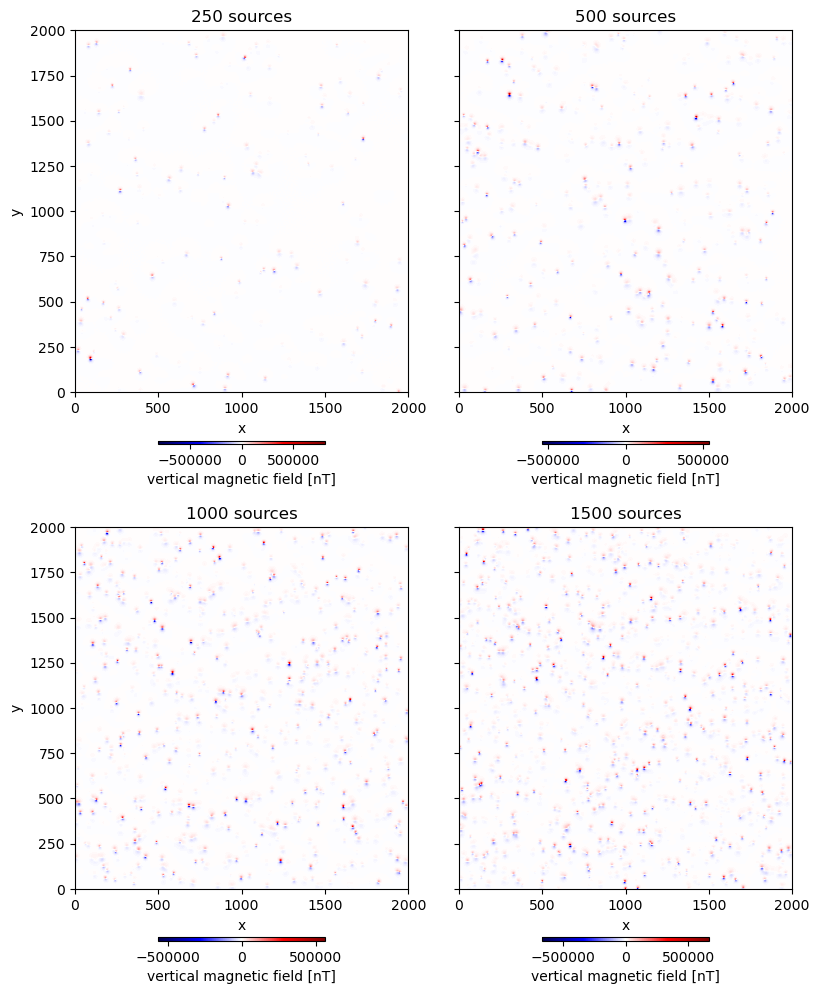

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.5)

for field, ax, count in zip(variable_name, axes.ravel(), count_sources):
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{count} sources')
for ax in axes.ravel():
    ax.set_aspect("auto")
    
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

for name in variable_name:

    if name == variable_name[0]:
        data_up = (
            hm.upward_continuation(data[name], height_difference)
            .assign_attrs(data[name].attrs)
            .to_dataset(name=name)
            .assign_coords(x=data.x, y=data.y)
            .assign_coords(z=data.z + height_difference)
        )
    else:
        data_up_aux = (
            hm.upward_continuation(data[name], height_difference)
            .assign_attrs(data[name].attrs)
            .to_dataset(name=name)
            .assign_coords(x=data.x, y=data.y)
            .assign_coords(z=data.z + height_difference)
        )
        
        data_up.update(data_up_aux)

data_up


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz250    (y, x) float64 166.5 145.7 129.9 117.6 ... 249.8 221.7 196.6 173.8
    bz500    (y, x) float64 -537.7 -727.0 -956.3 ... -89.14 -166.8 -272.9
    bz1000   (y, x) float64 27.21 26.2 25.44 24.44 ... 62.95 56.95 52.0 47.96
    bz1500   (y, x) float64 82.92 93.23 100.0 103.9 ... 157.3 156.0 157.3 162.2

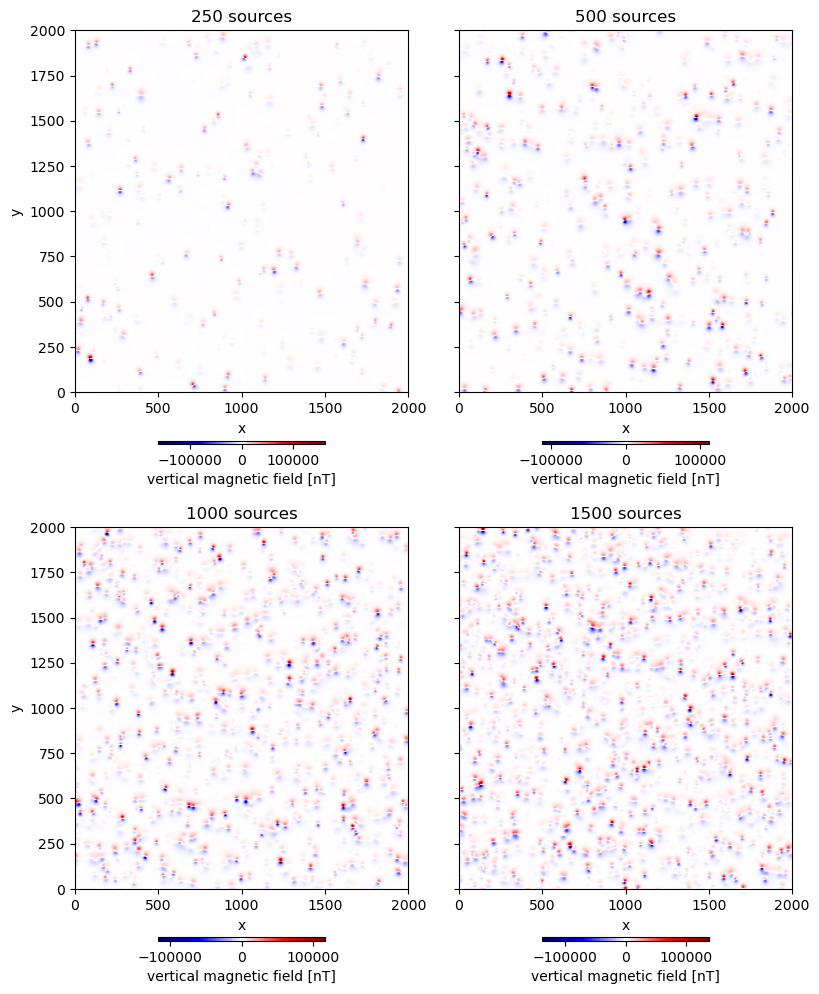

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.5)

for field, ax, count in zip(variable_name, axes.ravel(), count_sources):
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{count} sources')
for ax in axes.ravel():
    ax.set_aspect("auto")
    
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
# Modified data_gradients function for dealing with more than one maps
def data_gradients(data, prefix=None):
    """
    Add the derivatives and total gradient amplitude
    """
    dx = data.differentiate("x")
    dy = data.differentiate("y")
    spacing = np.mean([np.abs(data.x[1] - data.x[0]), np.abs(data.y[1] - data.y[0])])
    # Need to set the exact same coordinates because the xrft inverse transform
    # creates slightly different ones because of round-off errors.
    data_up = hm.upward_continuation(data, spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    data_down = hm.upward_continuation(data, -spacing).assign_coords(
        dict(x=data.x, y=data.y)
    )
    # Forward difference only to avoid downward continuation.
    dz = (data_up - data_down) / (2 * spacing)
    tga = np.sqrt(dx**2 + dy**2 + dz**2)
    tga.attrs = {"long_name": "total gradient amplitude", "units": "nT/µm"}
    dx.attrs = {"long_name": "x-derivative", "units": "nT/µm"}
    dy.attrs = {"long_name": "y-derivative", "units": "nT/µm"}
    dz.attrs = {"long_name": "z-derivative", "units": "nT/µm"}
    return xr.Dataset({f"{prefix}_tga": tga, f"{prefix}_x_deriv": dx, f"{prefix}_y_deriv": dy, f"{prefix}_z_deriv": dz})


In [12]:
for name in variable_name:
    data_up = data_up.assign(data_gradients(data_up[name], prefix=name))
data_up

<xarray.Dataset>
Dimensions:         (y: 1001, x: 1001)
Coordinates:
  * x               (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y               (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables: (12/20)
    bz250           (y, x) float64 166.5 145.7 129.9 117.6 ... 221.7 196.6 173.8
    bz500           (y, x) float64 -537.7 -727.0 -956.3 ... -89.14 -166.8 -272.9
    bz1000          (y, x) float64 27.21 26.2 25.44 24.44 ... 56.95 52.0 47.96
    bz1500          (y, x) float64 82.92 93.23 100.0 103.9 ... 156.0 157.3 162.2
    bz250_tga       (y, x) float64 26.21 24.52 21.67 19.58 ... 35.45 31.77 29.11
    bz250_x_deriv   (y, x) float64 -10.41 -9.144 -7.021 ... -13.29 -11.99 -11.42
    ...              ...
    bz1000_y_deriv  (y, x) float64 -8.072 -7.757 -7.563 ... -10.07 -9.327 -8.665
    bz1000_z_deriv  (y, x) float64 4.251 3.568 2.865 2.749 ... 3.1 2.786 2.657
    bz1500_tga      (y, x) float64 40.44 38.73 38.11 37.95 ... 48.8 46.17 43.63
    bz1500_x_deriv  (y, x) float64 5.155 4.272 2.671 ... 0.005024 1.549 2.436
    bz1500_y_deriv  (y, x) float64 -37.82 -37.18 -37.0 ... -48.13 -45.57 -43.21
    bz1500_z_deriv  (y, x) float64 13.35 10.0 8.736 8.725 ... 8.058 7.263 5.555

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
for name in variable_name:
    stretched = skimage.exposure.rescale_intensity(
        data_up[name+'_tga'], 
        in_range=tuple(np.percentile(data_up[name+'_tga'], (1, 99))),
    )

    tga_name = "tga_stretched_" + name
    tga = xr.DataArray(stretched, coords=data_up.coords)
    new_dataset = {tga_name: tga}
    data_up.update(new_dataset)
    
data_up

<xarray.Dataset>
Dimensions:               (y: 1001, x: 1001)
Coordinates:
  * x                     (x) float64 0.0 2.0 4.0 ... 1.996e+03 1.998e+03 2e+03
  * y                     (y) float64 0.0 2.0 4.0 ... 1.996e+03 1.998e+03 2e+03
    z                     (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0
Data variables: (12/24)
    bz250                 (y, x) float64 166.5 145.7 129.9 ... 221.7 196.6 173.8
    bz500                 (y, x) float64 -537.7 -727.0 -956.3 ... -166.8 -272.9
    bz1000                (y, x) float64 27.21 26.2 25.44 ... 56.95 52.0 47.96
    bz1500                (y, x) float64 82.92 93.23 100.0 ... 156.0 157.3 162.2
    bz250_tga             (y, x) float64 26.21 24.52 21.67 ... 35.45 31.77 29.11
    bz250_x_deriv         (y, x) float64 -10.41 -9.144 -7.021 ... -11.99 -11.42
    ...                    ...
    bz1500_y_deriv        (y, x) float64 -37.82 -37.18 -37.0 ... -45.57 -43.21
    bz1500_z_deriv        (y, x) float64 13.35 10.0 8.736 ... 8.058 7.263 5.555
    tga_stretched_bz250   (y, x) float64 0.012 0.01121 ... 0.01457 0.01334
    tga_stretched_bz500   (y, x) float64 0.03444 0.03857 ... 0.02528 0.02768
    tga_stretched_bz1000  (y, x) float64 0.0007177 0.0006001 ... 0.0007476
    tga_stretched_bz1500  (y, x) float64 0.004414 0.004156 ... 0.005281 0.004897

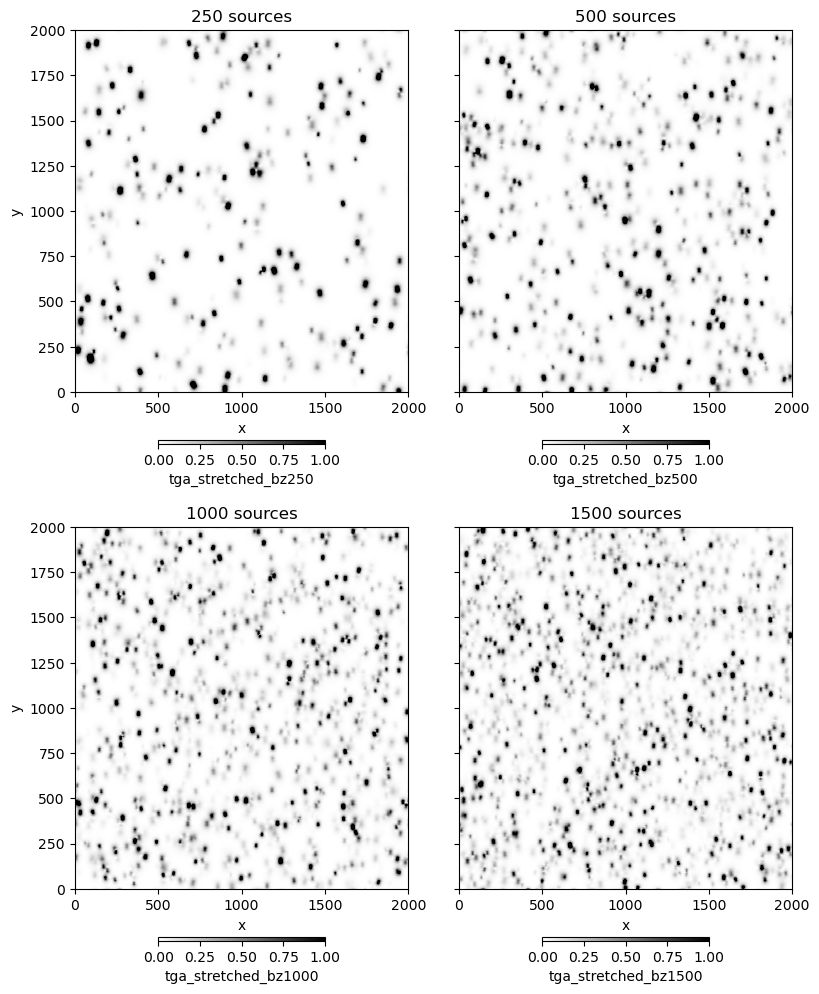

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.5)

for field, ax, count in zip(variable_name, axes.ravel(), count_sources):
    data_up['tga_stretched_'+(field)].plot.pcolormesh(ax=ax, cmap="gray_r", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{count} sources')
for ax in axes.ravel():
    ax.set_aspect("auto")
    
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
all_windows = []
for name in variable_name:
    tga_name = "tga_stretched_" + name

    windows = mg.detect_anomalies(
        data_up[tga_name], 
        size_range=[10, 100],
        size_increment=1.0,
        threshold=0.01,
        overlap=1.0,
        exclude_border=15
    )
    all_windows.append(windows)

In [16]:
for windows in all_windows:
    print('Sources detected: ', np.shape(windows)[0])

Sources detected:  227
Sources detected:  408
Sources detected:  760
Sources detected:  1013


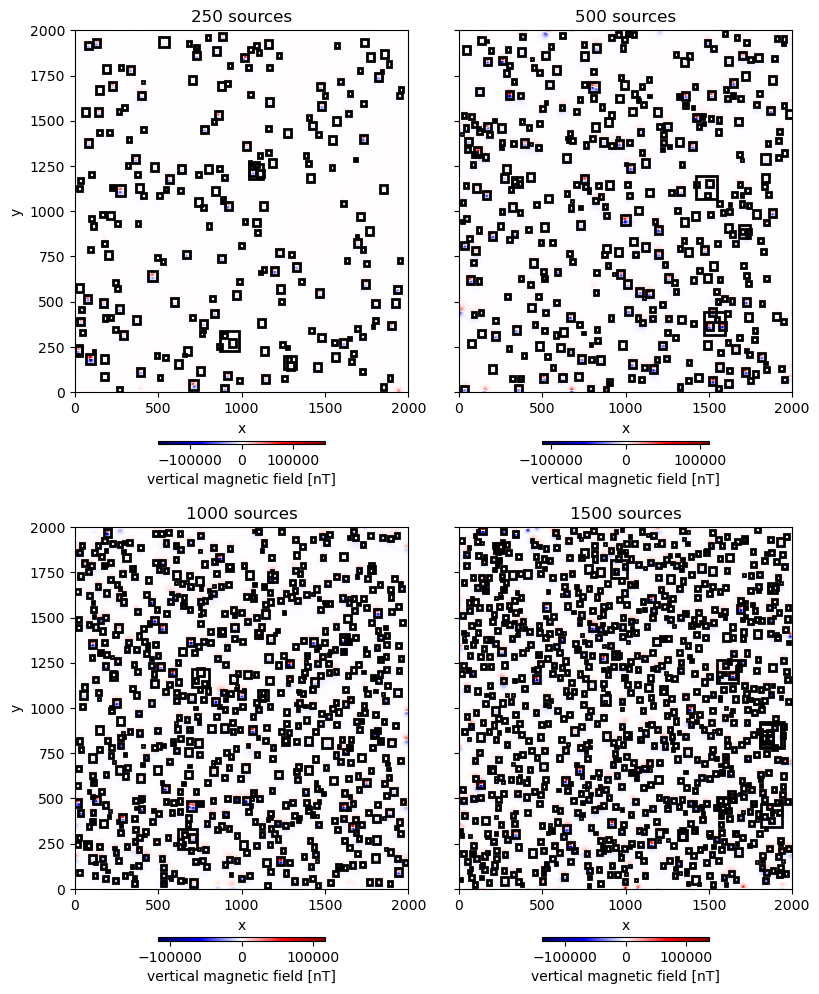

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.5)

for field, ax, count, windows in zip(variable_name, axes.ravel(), count_sources, all_windows):
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{count} sources')
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect) 
    
for ax in axes.ravel():
    ax.set_aspect("auto")
    
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [18]:
all_positions = []
all_estimated_dipole_moments = []
all_estimated_stds = []
all_calculated_r2 = []
all_calculated_SNR = []
all_windows_filtered = []

for name, windows in zip(variable_name, all_windows):
    positions = []
    estimated_dipole_moments = []
    estimated_stds = []
    calculated_r2 = []
    calculated_SNR = []
    windows_filtered = []
    base_levels = []
    
    for window in windows:
        anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        position, base_level = mg.euler_deconvolution(
            anomaly[name], 
            anomaly[name+'_x_deriv'], 
            anomaly[name+'_y_deriv'], 
            anomaly[name+'_z_deriv'],
        )

        anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        base_level = 0
        data_minus_background = anomaly[name].values                         #- base_level
        
        anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
        anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}

        moment, covariance, r2, SNR = mg.dipole_moment_inversion(
            anomaly.data_minus_background, position,
        )

        # Filter out solutions that don't meet quality criteria
        bad_euler = position[2] > 0
        poor_fit = False
#         r2_limit, SNR_limit = (0.95, 10)
#         poor_fit = (r2 < r2_limit) and (SNR > SNR_limit)
        if bad_euler or poor_fit:
            continue

        positions.append(position)  
        estimated_dipole_moments.append(moment)
        estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
        calculated_r2.append(r2)
        calculated_SNR.append(SNR)
        windows_filtered.append(window)
        base_levels.append(base_level)
    positions = np.transpose(positions)

    print()
    if poor_fit == False:
        print(f"{positions.shape[1]} dipole moments estimated")  
    else:
        print(f"{positions.shape[1]} dipole moments estimated with r2 = {r2_limit} and SNR = {SNR_limit}")    
    
    all_positions.append(positions)
    all_estimated_dipole_moments.append(estimated_dipole_moments)
    all_estimated_stds.append(estimated_stds)
    all_calculated_r2.append(calculated_r2)
    all_calculated_SNR.append(calculated_SNR)
    all_windows_filtered.append(windows_filtered)




225 dipole moments estimated

408 dipole moments estimated

759 dipole moments estimated

1007 dipole moments estimated


Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [19]:
all_closest = []
all_z_difference = []

for (dipole_coordinates, dipole_moments), name, positions in zip(models, variable_name, all_positions):
    
    dipole_coordinates_ = (dipole_coordinates[0][0], dipole_coordinates[0][1], dipole_coordinates[0][2])

    tree = sp.spatial.KDTree(np.transpose(dipole_coordinates_))
    closest = tree.query(np.transpose(positions))[1]
    z_difference = positions[2] - np.array(dipole_coordinates_[2])[closest]
    
    all_closest.append(closest)
    all_z_difference.append(z_difference)
    
# z_difference

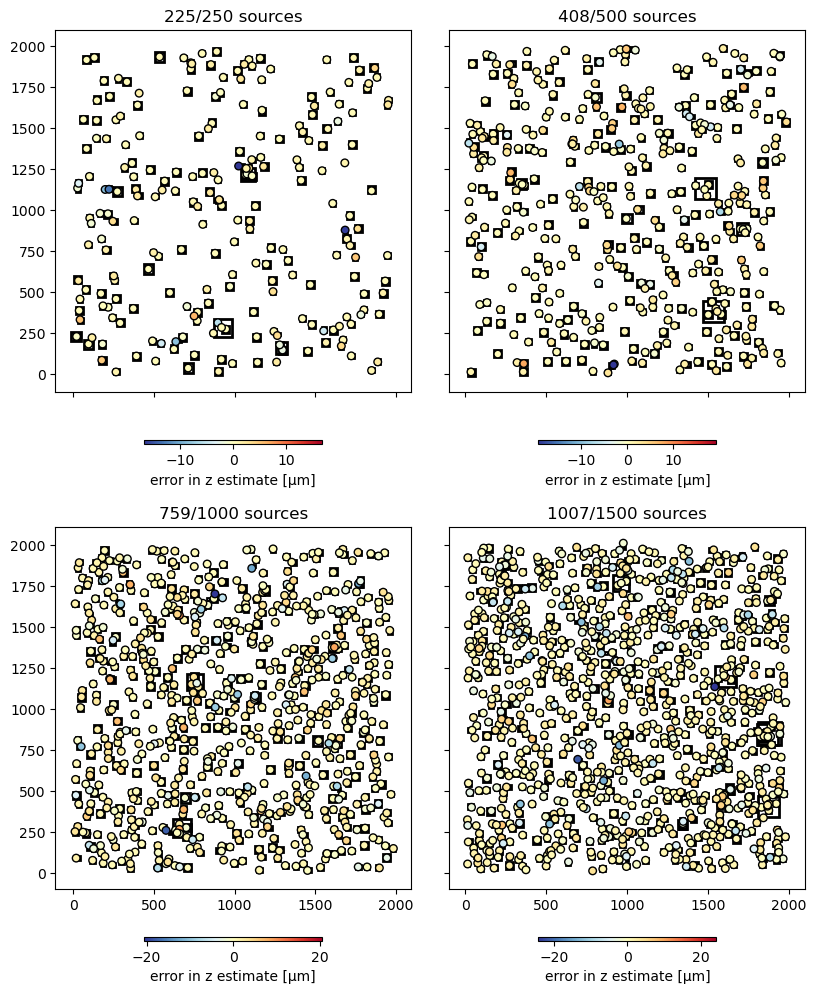

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row", sharex='col')
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.5)

for field, ax, count, windows, positions, z_difference in zip(
    variable_name, axes.ravel(),count_sources, all_windows_filtered, all_positions, all_z_difference):
#     data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
    ax.set_title(f'{np.shape(windows)[0]}/{count} sources')
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=2,
        )
        ax.add_patch(rect) 

    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
    fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

for ax in axes.ravel():
    ax.set_aspect("auto")
    
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)

plt.tight_layout(pad=0, h_pad=0, w_pad=2)

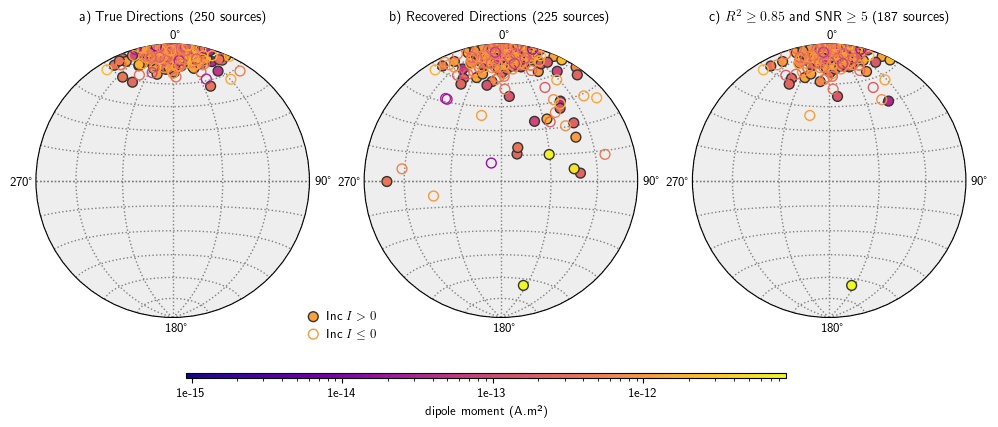

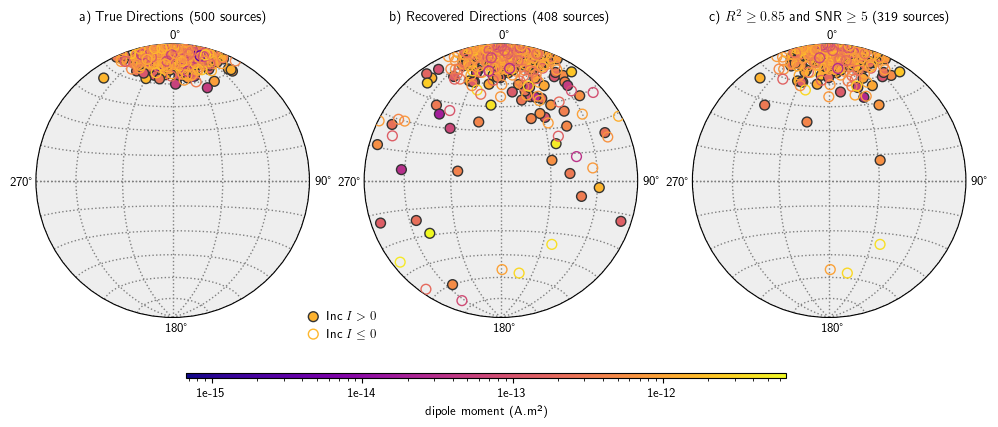

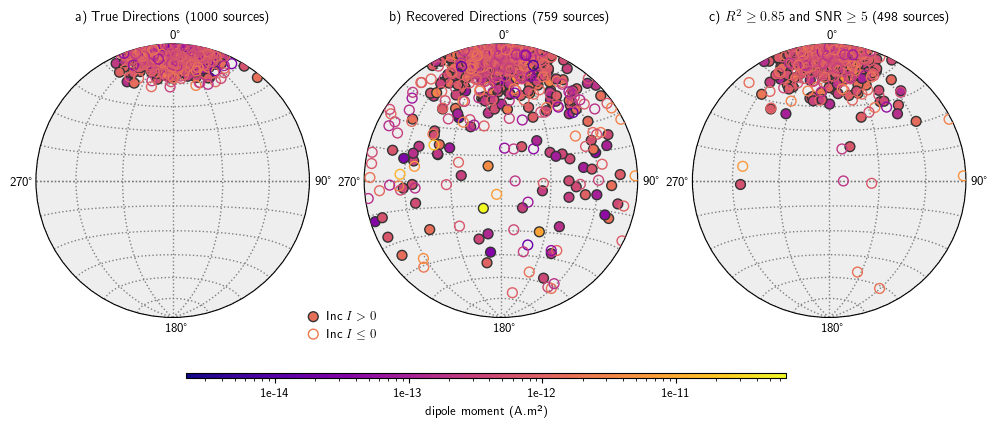

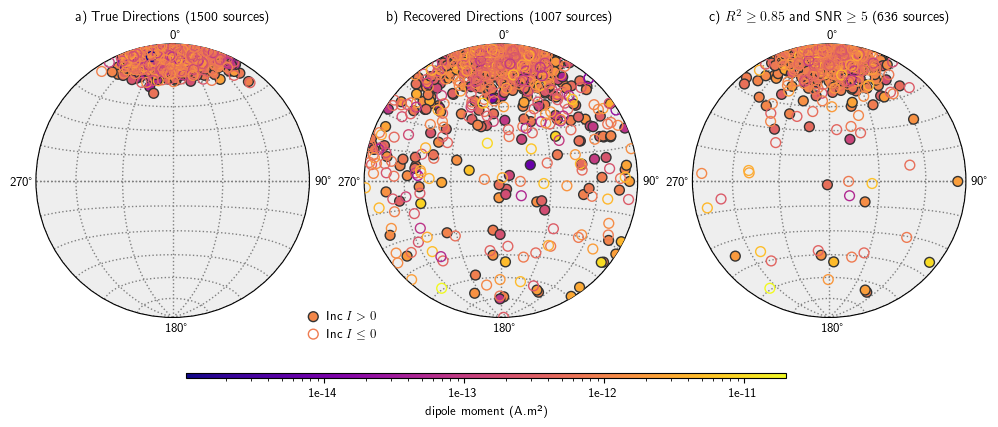

In [36]:
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

with plt.rc_context(mpl_rc):
    
    for (_, dipole_moments), estimated_dipole_moments, calculated_r2, calculated_SNR, name,  in zip(
        models, all_estimated_dipole_moments, all_calculated_r2, all_calculated_SNR, variable_name):
        
        fig = plt.figure(figsize=(12, 5))
        axes = []
        
        
        #############
        ax = fig.add_subplot(1, 3, 1, projection='stereonet')
        axes.append(ax)    
        estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
        true = mg.vector_to_angles(dipole_moments)[2]
        vmin = np.min((np.min(estimated), np.min(true)))
        vmax = np.max((np.max(estimated), np.max(true)))
        cmap = "plasma"
        # Use matplotlib.colors.LogNorm for a log scale
        cmap_norm = matplotlib.colors.LogNorm #Normalize
        kwargs = dict(
            ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
        )    
        tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs)

        
        
        #############
        ax = fig.add_subplot(1, 3, 2, projection='stereonet')
        axes.append(ax)    

        kwargs = dict(
            ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
        )    
        tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
        ax.legend(loc=(-0.25, -0.1), frameon=False, handletextpad=0.1)
        fig.colorbar(
            tmp, 
            cax=fig.add_axes([0.25, 0.1, 0.5, 0.01]), 
            format="%.0g",
            label="dipole moment (A.m²)",
            orientation="horizontal",
        )
        
        r2_limit, SNR_limit = (0.85, 5)
        pos_filter= ( (np.array(calculated_r2) > r2_limit) & (np.array(calculated_SNR) > SNR_limit))

        filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                          np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                          np.array(estimated_dipole_moments)[:,2][pos_filter]
                                         ]).T
        
        
        ############
        ax = fig.add_subplot(1, 3, 3, projection='stereonet')
        axes.append(ax)    

        kwargs = dict(
            ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
        )    
        tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

        titles = (f'a) True Directions ({len(dipole_moments)} sources)', 
                  f'b) Recovered Directions ({len(estimated_dipole_moments)} sources)', 
                  f'c) $R^2 \geq {r2_limit}$ and SNR $\geq {SNR_limit}$ ({len(filter_estimated_d_m[:,2])} sources)')

        for ax, letter, title in zip(axes, "a b c".split(), titles):
#             ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=10)
            ax.set_azimuth_ticks([])
            ax.grid(linestyle=':', color='gray')
            ax.set_title(title+'\n', fontsize=10, loc='center')
        fig.subplots_adjust(wspace=0.2)

plt.show()

In [22]:
# direction_misfit = []
# magnetic_moment_misfit = []

# for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
#     einc, edec, eamp = mg.vector_to_angles(estimated)
#     inc, dec, amp = mg.vector_to_angles(true)
#     sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
#     # Calculate misfits
#     dir_misfit = float(np.degrees(mplstereonet.angular_distance(
#                             mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
#     magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
#     direction_misfit.append(dir_misfit)
#     magnetic_moment_misfit.append(magm_mom_misfit)
    
#     # print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
#     # print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
#     # print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
#     # print(f"R²   : {r2:.5f} ")
#     # print(f"SNR  : {SNR:.5f} ")
#     # print(f"Direction Misfit  : {dir_misfit:.2f}° ")
#     # print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
#     # print()

In [23]:
# fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
# ax.grid()
# estimated = mg.vector_to_angles(estimated_dipole_moments)
# true = mg.vector_to_angles(dipole_moments)
# scatter_args = dict(
#     vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
#     vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
#     cmap="summer",
#     edgecolors="#333333",
#     linewidths=1,
#     s=70,
#     zorder=2,
# )
# pos_inc = estimated[0] > 0
# tmp = ax.scatter(
#     *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
#     c=estimated[2][pos_inc],
#     marker="o",
#     **scatter_args,
# )
# tmp = ax.scatter(
#     *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
#     c=estimated[2][~pos_inc],
#     marker="s",
#     **scatter_args,
# )
# pos_inc = true[0] > 0
# tmp = ax.scatter(
#     *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
#     c=true[2][pos_inc],
#     marker="^",
#     **scatter_args,
# )
# tmp = ax.scatter(
#     *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
#     c=true[2][~pos_inc],
#     marker="v",
#     **scatter_args,
# )
# fig.colorbar(
#     tmp, 
#     cax=fig.add_axes([0, -0.1, 1, 0.02]), 
#     orientation="horizontal", 
#     label="dipole moment [$A.m^2$]",
#     format="%.0e",
# )
# plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [24]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

In [25]:
# vmax=+10000
# vmin=-10000
# with plt.rc_context(mpl_rc):

#     fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row", sharex="col")
#     axes = axes.ravel()    
#     cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
#     ax = axes[0]
#     ax.set_aspect("auto")
#     ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
#     tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
#     ax = axes[1]
#     ax.set_aspect("auto")
#     ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
#     ax.set_xlabel("x ($\mu$m)")
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
#     ax = axes[2]   
#     ax.set_aspect("auto")
#     ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
#     ax.set_xlabel("x ($\mu$m)")
#     tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
#     fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
#     ax = axes[3]  
#     ax.set_aspect("auto")
#     ax.set_title(f"Contrast-stretched TGA")
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
#     tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
#     fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
#     ax = axes[4]  
#     ax.set_aspect("auto")
#     ax.set_title(f"Detected source bounding boxes")
#     ax.set_xlabel("x ($\mu$m)")
#     tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
#     for window in windows:
#         rect = matplotlib.patches.Rectangle(
#             xy=[window[0], window[2]],
#             width=window[1] - window[0],
#             height=window[3] - window[2],
#             edgecolor="k",
#             fill=False,
#             linewidth=1,
#         )
#         ax.add_patch(rect)   

#     ax = axes[5]  
#     ax.set_aspect("auto")
#     ax.set_title(f"Estimated source locations")
#     ax.set_xlabel("x ($\mu$m)")
#     scale = 100
# #     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
#     for window in windows:
#         rect = matplotlib.patches.Rectangle(
#             xy=[window[0], window[2]],
#             width=window[1] - window[0],
#             height=window[3] - window[2],
#             edgecolor="k",
#             fill=False,
#             linewidth=1,
#         )
#         ax.add_patch(rect)
#     scale = vd.maxabs(z_difference)
#     tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
#     fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
#     for ax, letter in zip(axes, "a b c d e f".split()):
#         ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

#     plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
# #     fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
#     plt.show()

In [26]:
# with plt.rc_context(mpl_rc):
#     size=8
#     fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

#     axes = axes.ravel()
#     ax = axes[0]
#     ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
#     ax.set_ylabel('Direction error (°)')
#     ax.set_xlabel('$R^2$')
#     ax.set_yscale('log')
#     ax = ax.twinx()
#     ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
#     ax.set_ylabel('Dipole moment error (\%)', color='r')
#     ax.tick_params(axis='y', colors='red')
#     ax.set_yscale('log')

#     ax = axes[1]
#     ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
#     ax.set_ylabel('Direction error (°)')
#     ax.set_xlabel('SNR')
#     ax.set_yscale('log')
#     ax = ax.twinx()
#     ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
#     ax.set_xlabel('SNR')
#     ax.set_ylabel('Dipole moment error (\%)', color='r')
#     ax.tick_params(axis='y', colors='red')
#     ax.set_yscale('log')

#     ax = axes[2]
#     ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
#     ax.set_xlabel('$R^2$')
#     ax.set_ylabel('SNR')

#     titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
#     for ax, letter, title in zip(axes, "a b c".split(), titles):
#         ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
#         ax.set_aspect("auto")
#         ax.grid(alpha=0.3, which='major')
#         ax.set_title(title)




#     plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
# #     fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

In [27]:
# inc, dec, amp = mg.vector_to_angles(dipole_moments)
# einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

# scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
# scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

# vmax=+10000
# vmin=-10000

# with plt.rc_context(mpl_rc):

#     fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row", sharex="col")
#     axes = axes.ravel()    
#     cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
#     ax = axes[0]
#     ax.set_aspect("equal")
#     ax.set_title("Direction Misfit", fontsize=13)
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    

#     scale = 20
#     tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
#     fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
#     ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
#     ax = axes[1]
#     ax.set_aspect("equal")
#     ax.set_title("Magnetic Moment Misfit", fontsize=13)
#     ax.set_xlabel("x ($\mu$m)")

#     scale = 20
#     tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
#     fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
#     ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
#     ax = axes[2]   
#     ax.set_aspect("equal")
#     ax.set_title(f"$R^2$", fontsize=13)
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")

#     scale = 0.85
#     tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
#     fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
#     ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
#     ax = axes[3]  
#     ax.set_aspect("equal")
#     ax.set_title(f"SNR", fontsize=13)
#     ax.set_xlabel("x ($\mu$m)")
    
#     scale = 20
#     tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
#     fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
#     ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
#     for ax, letter in zip(axes, "a b c d".split()):
#         ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
#         ax.set_aspect("equal")
# #         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
#     plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
#     left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
#     ax5 = fig.add_axes([left, bottom, width, height])
#     ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
#                  fmt='o', zorder=0, color='gray')
#     ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
#     ax5.set_ylim(-1.0, 1.5)
#     ax5.set_xlim(-0.6, 1.1)

#     ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
#     ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
#     ax5.scatter(-0.15, -0.0, marker='v', color='k')
#     ax5.scatter(-0.15, 1.0, marker='^', color='k')

#     ax5.scatter(0.2,-0.15, marker='<', color='k')
#     ax5.scatter(0.8,-0.15, marker='>', color='k')

#     ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
#     ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

#     ax5.set_title('', loc='left')
#     # Eliminate upper and right axes
#     ax5.spines['right'].set_color('none')
#     ax5.spines['top'].set_color('none')
#     ax5.spines['bottom'].set_color('none')
#     ax5.spines['left'].set_color('none')
#     ax5.xaxis.set_ticks([])
#     ax5.yaxis.set_ticks([])
    
# #     fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
#     plt.show()


In [28]:
# with plt.rc_context(mpl_rc):
#     fig = plt.figure(figsize=(12, 5))
#     axes = []
    
#     ax = fig.add_subplot(1, 3, 1, projection='stereonet')
#     axes.append(ax)    
#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     true = mg.vector_to_angles(dipole_moments)[2]
#     vmin = np.min((np.min(estimated), np.min(true)))
#     vmax = np.max((np.max(estimated), np.max(true)))
#     cmap = "plasma"
#     # Use matplotlib.colors.LogNorm for a log scale
#     cmap_norm = matplotlib.colors.LogNorm #Normalize
#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
#     tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs)

    
#     ax = fig.add_subplot(1, 3, 2, projection='stereonet')
#     axes.append(ax)    

#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
#     tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
#     ax.legend(loc=(-0.25, -0.1), frameon=False, handletextpad=0.1)
#     fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.1, 0.5, 0.01]), 
#         format="%.0g",
#         label="dipole moment (A.m²)",
#         orientation="horizontal",
#     )
    
#     pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

#     filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,1][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,2][pos_filter]
#                                      ]).T
    
#     ax = fig.add_subplot(1, 3, 3, projection='stereonet')
#     axes.append(ax)    

#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
#     tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

#     titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

#     for ax, letter, title in zip(axes, "a b c".split(), titles):
#         ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
#         ax.set_azimuth_ticks([])
#         ax.grid(linestyle=':', color='gray')
#         ax.set_title(title+'\n', fontsize=13, loc='center')
#     fig.subplots_adjust(wspace=0.2)

#     plt.show()


In [29]:
# with plt.rc_context(mpl_rc):
#     fig = plt.figure(figsize=(12, 5))
    
#     axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     true = mg.vector_to_angles(dipole_moments)[2]
#     vmin = np.min( (np.min(estimated), np.min(true)))
#     vmax = np.max( (np.max(estimated), np.max(true)))
#     cmap = "plasma"

#     cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#     ax = fig.add_subplot(1, 3, 1)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
# #     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         dipole_coordinates, dipole_moments, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
#     ax.set_aspect("equal")
    
    
#     ax = fig.add_subplot(1, 3, 2)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
# #     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         positions, estimated_dipole_moments, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
# #     ax.set_ylabel("y ($\mu$m)")
#     ax.set_aspect("equal")

#     # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
#     ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k')
#     ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k')
#     ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k')
#     ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k')
#     ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k')
    
    
    
    
    
#     pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

#     filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,1][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,2][pos_filter] 
#                                      ]).T
    
#     filter_positions = np.array( [np.array(positions)[0][pos_filter], 
#                                   np.array(positions)[1][pos_filter], 
#                                   np.array(positions)[2][pos_filter]
#                                  ])
    
#     ax = fig.add_subplot(1, 3, 3)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
# #     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         filter_positions, filter_estimated_d_m, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
# #     ax.set_ylabel("y ($\mu$m)")
#     ax.set_aspect("equal")
    
#     fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.0, 0.5, 0.01]), 
#         format="%.0e",
#         label="dipole moment (A.m²)",
#         orientation="horizontal",
#     )
    

#     titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

#     for ax, letter, title in zip(axes, "a b c".split(), titles):
#         ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=13)
#         ax.set_title(title, fontsize=13)
#     fig.subplots_adjust(wspace=0.2)
    
#     plt.show()


In [30]:
# with plt.rc_context(mpl_rc):
#     fig = plt.figure(figsize=(15, 10))
    
#     axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     true = mg.vector_to_angles(dipole_moments)[2]
#     vmin = np.min( (np.min(estimated), np.min(true)))
#     vmax = np.max( (np.max(estimated), np.max(true)))
#     cmap = "plasma"

#     cmap_norm = matplotlib.colors.LogNorm #Normalize
    
# #################################################################################################
# #                                             Maps
# #################################################################################################
#     ax = fig.add_subplot(2, 3, 1)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
 
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         dipole_coordinates, dipole_moments, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")

    
    
#     ax = fig.add_subplot(2, 3, 2)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         positions, estimated_dipole_moments, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
#     plt.yticks(color='w')
    
#     # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
#     ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
#                  fontproperties={'size': 'x-large', 'weight': 'bold'})
#     ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
#                  fontproperties={'size': 'x-large', 'weight': 'bold'})
#     ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k',
#                  fontproperties={'size': 'x-large', 'weight': 'bold'})
#     ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k',
#                  fontproperties={'size': 'x-large', 'weight': 'bold'})
#     ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k',
#                  fontproperties={'size': 'x-large', 'weight': 'bold'})
    

#     pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

#     filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,1][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,2][pos_filter] 
#                                      ]).T
    
#     filter_positions = np.array( [np.array(positions)[0][pos_filter], 
#                                   np.array(positions)[1][pos_filter], 
#                                   np.array(positions)[2][pos_filter]
#                                  ])
    
#     ax = fig.add_subplot(2, 3, 3)
#     axes.append(ax)
#     ax.set_title("Estimated dipole moments over the synthetic $b_z$")
#     scale = 2000
#     data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
#                                    add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
#     tmp, posquiver, negquiver = mg.plot_dipole_moment(
#         filter_positions, filter_estimated_d_m, 
#         ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
#         scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
#     )
#     ax.set_xlabel("x ($\mu$m)")
#     plt.yticks(color='w')
    
#     clb = fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
#         format="%.0g",
# #         label="dipole moment (A.m²)",
#         orientation="horizontal"
#     )
    
#     clb.set_label(label="dipole moment ($A.m^2$)", fontsize=12)
    
#     clb.ax.tick_params(labelsize=12)
    
# #################################################################################################
# #                                           Stereograms
# #################################################################################################

#     ax = fig.add_subplot(2, 3, 4, projection='stereonet')
#     axes.append(ax)    
#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     true = mg.vector_to_angles(dipole_moments)[2]
#     vmin = np.min((np.min(estimated), np.min(true)))
#     vmax = np.max((np.max(estimated), np.max(true)))
#     cmap = "plasma"
#     # Use matplotlib.colors.LogNorm for a log scale
#     cmap_norm = matplotlib.colors.LogNorm #Normalize
#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
#     tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs, add_ticks=True)

    
#     ax = fig.add_subplot(2, 3, 5, projection='stereonet')
#     axes.append(ax)    

#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
    
#     tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
#     ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})

    
#     pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

#     filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,1][pos_filter], 
#                                       np.array(estimated_dipole_moments)[:,2][pos_filter]
#                                      ]).T
    
#     ax = fig.add_subplot(2, 3, 6, projection='stereonet')
#     axes.append(ax)    

#     kwargs = dict(
#         ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
#     )    
#     tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    
#     titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

#     for ax, letter, title in zip(axes, "a b c".split(), titles):
#         ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
#         ax.set_title(title, fontsize=14)
#         ax.set_aspect("auto")
    
        
#     fig.subplots_adjust(wspace=0.1, hspace=0.4)
# #     fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
#     plt.show()

### Show the observed and predicted data

In [31]:
# predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions, estimated_dipole_moments)
# residuo = data.bz.values - predicted_data

In [32]:
# data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
# data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

# error = data_up.bz.values - data_up.predicted_data.values

# data_up = data_up.assign(error=(['y','x'],error))
# data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}



In [33]:
# data_up

In [34]:
# fig, axes = plt.subplots(1, 3, figsize=(14, 6))
# cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
# for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
#     vmax = +10000
#     vmin = -10000
#     data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
# for ax in axes.ravel():
#     ax.set_aspect("equal")
# plt.tight_layout()

### Show each window results
We displayed only the first 5 windows

In [35]:
# for window, r2, SNR in zip(windows_filtered[0:5], calculated_r2[0:5], calculated_SNR[0:5]):
#     local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
#     fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
#     axes = axes.ravel()    
#     cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
#     ax = axes[0]
#     ax.set_aspect("auto")
#     ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
#     ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
#     tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
#     ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
#     ax = axes[1]
#     ax.set_aspect("auto")
#     ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
#     ax.set_xlabel("x ($\mu$m)")
#     tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
#     ax.scatter(positions[0], positions[1], color='w', marker='s', edgecolors='k')
    
#     ax = axes[2]   
#     ax.set_aspect("auto")
#     ax.set_title("error")
#     ax.set_xlabel("x ($\mu$m)")
    
#     tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
#     fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
#     residuals_sum_sq = np.sum((local_data.error.values)**2)
#     r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
#     SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
#     # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
#     print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))
#     print(r"Individual source:   R2 = %s and SNR = %s"%(r2, SNR))

#     plt.show()